In [1]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# Business Context

The U.S. Airbnb Open Data is a publicly available dataset that provides detailed information on Airbnb listings across various cities in the United States. It typically includes data such as listing ID, host information, property location, type of accommodation, pricing, availability, number of reviews, and review ratings. This dataset is often used for exploratory data analysis, price prediction, and tourism trend insights. It offers a valuable resource for researchers, data scientists, and analysts interested in the short-term rental market and its impact on local economies and housing.



# Objective


1. Understand the relationship between various features and listing prices. 
2. Build and evaluate multiple regression models to predict the prices of a Airbnb listing.
3. Provide actionable insights based on model findings.


# Data


In [5]:
# Load the dataset
# pandas shows an error about the datatype of neighbourhood_group column so we'll set it explicity as string
df = pd.read_csv('AirBnB_US_2023.csv', dtype={'neighbourhood_group': str})
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,city
0,958,"Bright, Modern Garden Unit - 1BR/1BTH",1169,Holly,NaN,Western Addition,37.77028,-122.43317,Entire home/apt,202,2,383,2023-02-19,2.31,1,128,59,San Francisco
1,5858,Creative Sanctuary,8904,Philip And Tania,NaN,Bernal Heights,37.74474,-122.42089,Entire home/apt,235,30,111,2017-08-06,0.66,1,365,0,San Francisco
2,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,21994,Aaron,NaN,Haight Ashbury,37.76555,-122.45213,Private room,56,32,9,2022-10-27,0.09,13,365,1,San Francisco
3,8339,Historic Alamo Square Victorian,24215,Rosy,NaN,Western Addition,37.77564,-122.43642,Entire home/apt,575,9,28,2019-06-28,0.17,2,365,0,San Francisco
4,8739,"Mission Sunshine, with Private Bath",7149,Ivan & Wendy,NaN,Mission,37.76030,-122.42197,Private room,110,1,770,2023-02-25,4.65,2,159,34,San Francisco


# Exploratory Data Analysis (EDA) and Data Cleansing
Let's explore the data


In [7]:
# Display basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232147 entries, 0 to 232146
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              232147 non-null  int64  
 1   name                            232131 non-null  object 
 2   host_id                         232147 non-null  int64  
 3   host_name                       232134 non-null  object 
 4   neighbourhood_group             96500 non-null   object 
 5   neighbourhood                   232147 non-null  object 
 6   latitude                        232147 non-null  float64
 7   longitude                       232147 non-null  float64
 8   room_type                       232147 non-null  object 
 9   price                           232147 non-null  int64  
 10  minimum_nights                  232147 non-null  int64  
 11  number_of_reviews               232147 non-null  int64  
 12  last_review     

We can see that most of columns have values for all rows. Some columns are missing the data, which we'll explore below


In [9]:
# Display the number of unique values for each column
df.nunique()

id                                232146
name                              220164
host_id                           119582
host_name                          29368
neighbourhood_group                   30
neighbourhood                       1412
latitude                          157966
longitude                         159988
room_type                              4
price                               2429
minimum_nights                       178
number_of_reviews                    861
last_review                         3147
reviews_per_month                   1367
calculated_host_listings_count       149
availability_365                     366
number_of_reviews_ltm                271
city                                  27
dtype: int64

In [10]:
# Display descriptive statistics
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2.321470e+05,2.321470e+05,232147.000000,232147.000000,232147.000000,232147.000000,232147.000000,183062.000000,232147.000000,232147.000000,232147.000000
mean,2.584580e+17,1.582248e+08,36.610585,-98.301436,259.468001,13.495867,40.915230,1.638348,29.879055,180.985686,11.689701
std,3.465985e+17,1.587164e+08,5.126523,19.706929,1024.645918,27.920631,80.649152,1.910812,106.013665,134.715299,20.599954
min,6.000000e+00,2.300000e+01,25.957323,-123.089130,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,2.638896e+07,2.299242e+07,33.976225,-118.315111,91.000000,2.000000,1.000000,0.310000,1.000000,52.000000,0.000000
50%,4.896307e+07,1.005783e+08,36.190556,-97.727670,149.000000,3.000000,9.000000,1.000000,2.000000,175.000000,3.000000
75%,6.633014e+17,2.686930e+08,40.717440,-77.026222,250.000000,30.000000,43.000000,2.420000,10.000000,321.000000,16.000000
max,8.581014e+17,5.069384e+08,47.734010,-70.996000,100000.000000,1250.000000,3091.000000,101.420000,1003.000000,365.000000,1314.000000


In [11]:
# Check for missing values
df.isnull().sum()

id                                     0
name                                  16
host_id                                0
host_name                             13
neighbourhood_group               135647
neighbourhood                          0
latitude                               0
longitude                              0
room_type                              0
price                                  0
minimum_nights                         0
number_of_reviews                      0
last_review                        49085
reviews_per_month                  49085
calculated_host_listings_count         0
availability_365                       0
number_of_reviews_ltm                  0
city                                   0
dtype: int64

The column **neighbourhood_group** has a lot of missing values. We can also see that there are 1412 unique values for the **neighbourhood** column. So it makes sense to drop the **neighbourhood_group** and use **neighbourhood** instead. Let's see what values we have for both columns.

In [13]:
print(df['neighbourhood_group'].unique())

print(df['neighbourhood'].unique()[:20])  # First 20 values
# see how they are related. How many neighbourhoods exist in each neighbourhood_group.
print(df.groupby('neighbourhood_group')['neighbourhood'].nunique())

[nan 'Other Cities' 'Unincorporated Areas' 'City of Los Angeles'
 'Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island' 'Providence'
 'Washington' 'Newport' 'Bristol' 'Kent' 'Central Area'
 'Other neighborhoods' 'Delridge' 'Magnolia' 'Beacon Hill' 'West Seattle'
 'Ballard' 'Queen Anne' 'Capitol Hill' 'Downtown' 'Cascade'
 'Rainier Valley' 'Northgate' 'Lake City' 'University District'
 'Seward Park' 'Interbay']
['Western Addition' 'Bernal Heights' 'Haight Ashbury' 'Mission' 'Bayview'
 'Outer Richmond' 'Nob Hill' 'Castro/Upper Market' 'Inner Richmond'
 'Noe Valley' 'Pacific Heights' 'Diamond Heights' 'Outer Mission' 'Marina'
 'Twin Peaks' 'Potrero Hill' 'Financial District' 'Chinatown' 'Glen Park'
 'Russian Hill']
neighbourhood_group
Ballard                   5
Beacon Hill               4
Bristol                   3
Bronx                    49
Brooklyn                 48
Capitol Hill              5
Cascade                   3
Central Area              6
City of Los Angeles     113
Delr

We see a lot of overlap betwen these two, so we will drop neighbourhood_group

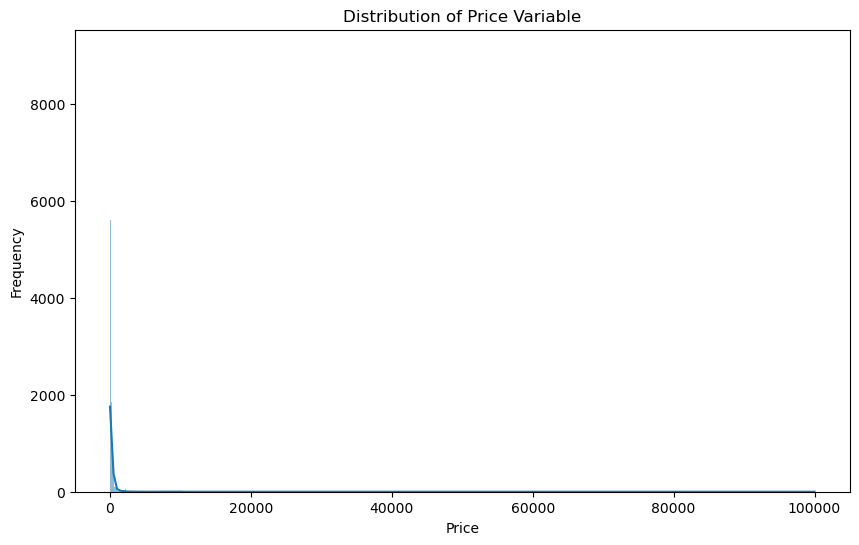

In [15]:
# Now let's visualize the distribution of the price variable
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Price Variable')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### Large values of Price
We can clearly see that there are some very large values of the Price. These could be either spurious data or luxury properties, which are not representative of the general listing. We will later remove values outside 5th–95th percentile for price.


In [17]:

# We also drop the free text fields because they are not useful unless processed specially (e.g., with NLP). 
# Text and category fields (e.g. 'room_type', 'neighbourhood', 'city') must be encoded.
df = df.drop(columns=['id', 'host_id', 'host_name', 'name', 'last_review', 'neighbourhood_group' ])

# Another aspect to notice is that we already have a good mix of cities (27 unique values), so the latitude and longitude are unlikely to capture any additional knowledge. We'll drop these columns as well.

df = df.drop(columns=['latitude', 'longitude'])

# Compute the 5th and 95th percentiles. 
lower = df['price'].quantile(0.05)
upper = df['price'].quantile(0.95)

# Keep only rows within that range
df = df[(df['price'] >= lower) & (df['price'] <= upper)]

In [18]:
# Fill missing reviews_per_month with 0 (assumes no reviews)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

df.head()

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,city
0,Western Addition,Entire home/apt,202,2,383,2.31,1,128,59,San Francisco
1,Bernal Heights,Entire home/apt,235,30,111,0.66,1,365,0,San Francisco
2,Haight Ashbury,Private room,56,32,9,0.09,13,365,1,San Francisco
3,Western Addition,Entire home/apt,575,9,28,0.17,2,365,0,San Francisco
4,Mission,Private room,110,1,770,4.65,2,159,34,San Francisco


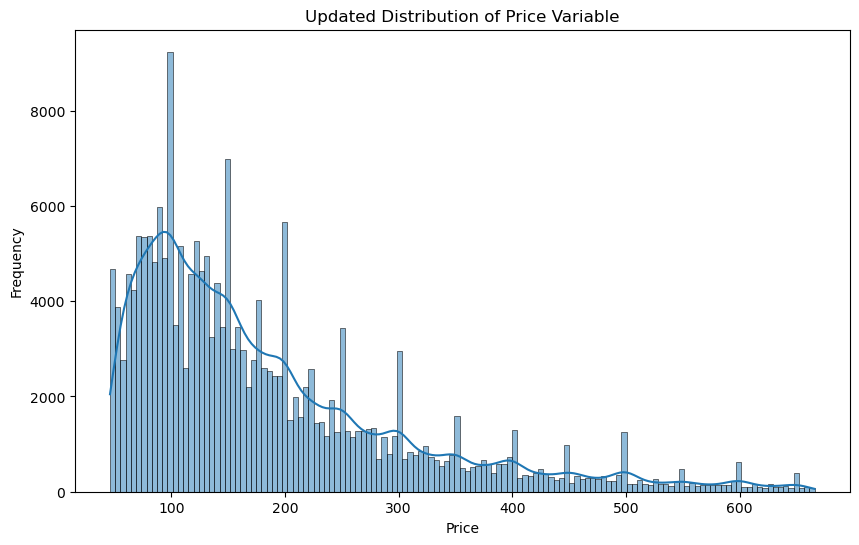

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Updated Distribution of Price Variable')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

city
Pacific Grove         270.729858
Santa Cruz County     259.070441
Rhode Island          244.157970
Broward County        225.182382
Nashville             222.679858
San Diego             218.692784
Austin                211.531058
Clark County          204.836367
New Orleans           201.796930
San Mateo County      187.534777
San Francisco         185.308014
Cambridge             178.634343
Los Angeles           178.207503
Boston                174.659461
Washington D.C.       171.127194
Jersey City           169.059240
Asheville             164.620667
Twin Cities MSA       164.567105
New York City         162.678446
Chicago               158.019948
Santa Clara County    155.460258
Seattle               155.439864
Denver                154.237567
Oakland               142.682729
Columbus              131.874116
Portland              129.381521
Salem                 123.082031
Name: price, dtype: float64


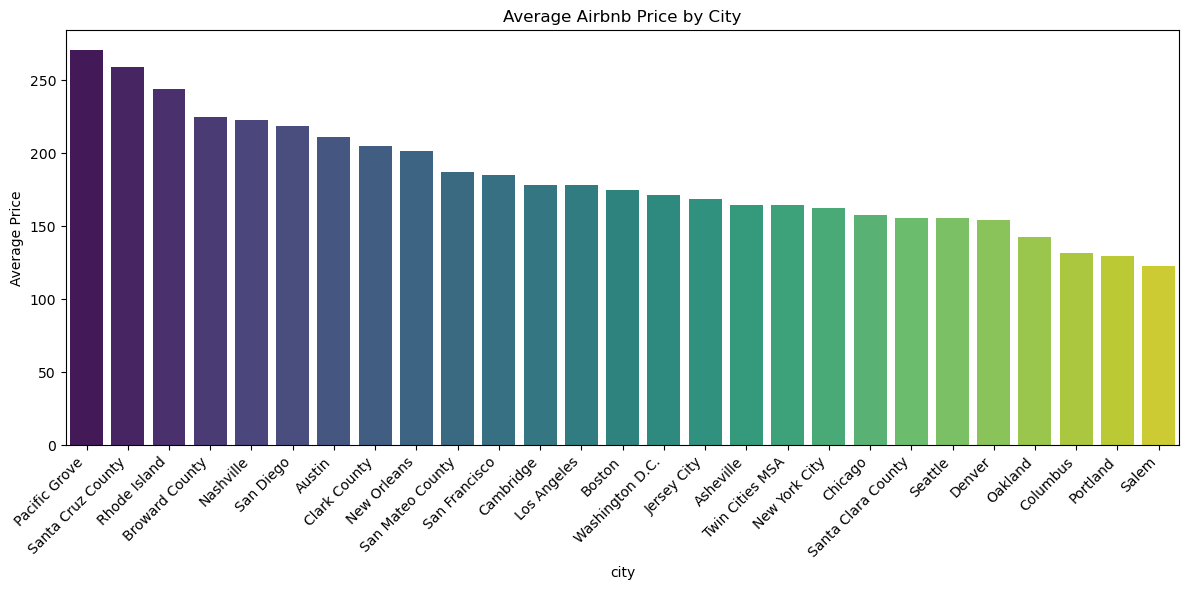

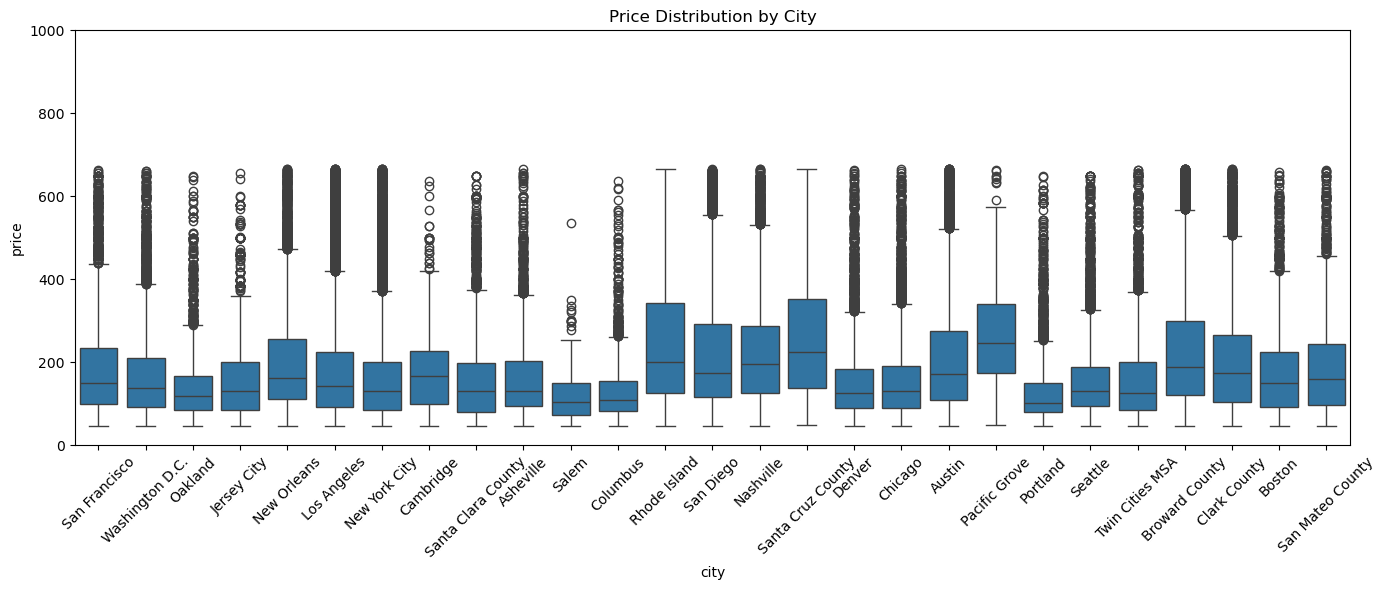

In [20]:
# Explore the prices per city
city_avg = df.groupby('city')['price'].mean().sort_values(ascending=False)
print(city_avg)

plt.figure(figsize=(12, 6))
sns.barplot(x=city_avg.index, y=city_avg.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Price")
plt.title("Average Airbnb Price by City")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='city', y='price')
plt.xticks(rotation=45)
plt.ylim(0, 1000)  # Optional: cap at 1000 to reduce effect of outliers
plt.title("Price Distribution by City")
plt.tight_layout()
plt.show()

In [21]:
# Encode categorical features
from sklearn.preprocessing import LabelEncoder

for col in ['neighbourhood', 'city', 'room_type']:
    df[col] = LabelEncoder().fit_transform(df[col])

In [22]:
df.head()

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,city
0,1371,0,202,2,383,2.31,1,128,59,20
1,151,0,235,30,111,0.66,1,365,0,20
2,569,2,56,32,9,0.09,13,365,1,20
3,1371,0,575,9,28,0.17,2,365,0,20
4,818,2,110,1,770,4.65,2,159,34,20


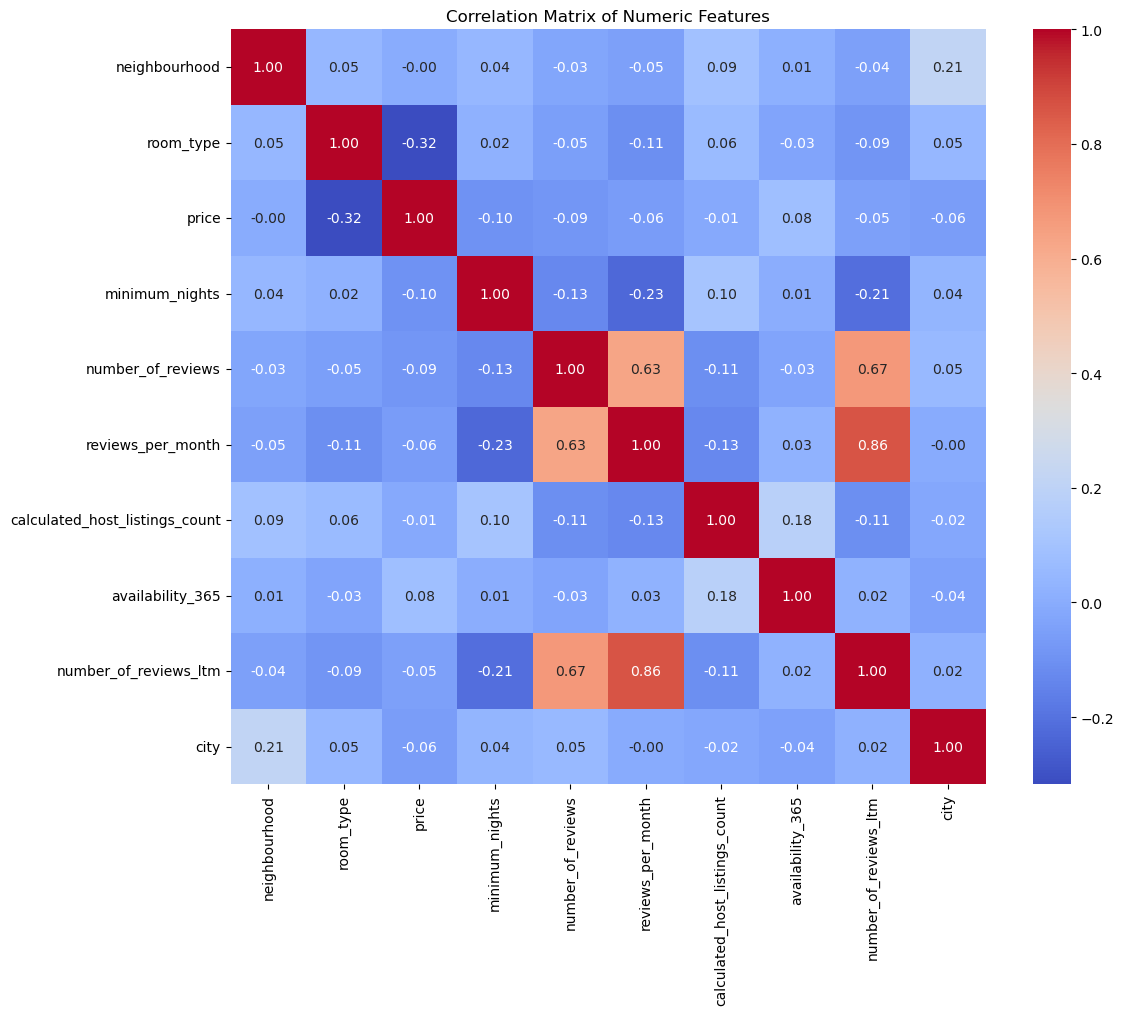

Top correlations with price:
 price                             1.000000
room_type                         0.317377
minimum_nights                    0.098785
number_of_reviews                 0.085176
availability_365                  0.081945
reviews_per_month                 0.061086
city                              0.056267
number_of_reviews_ltm             0.046810
calculated_host_listings_count    0.009428
neighbourhood                     0.002605
Name: price, dtype: float64


In [23]:
# Visualize correlations
#plt.figure(figsize=(12, 8))
#sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
#plt.title('Correlation Matrix')
#plt.show()

# Select only numeric columns (exclude one-hot encoded categories)
numeric_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# Sort correlations by strength of relationship with price
sorted_corr = corr_matrix['price'].abs().sort_values(ascending=False)
print("Top correlations with price:\n", sorted_corr)

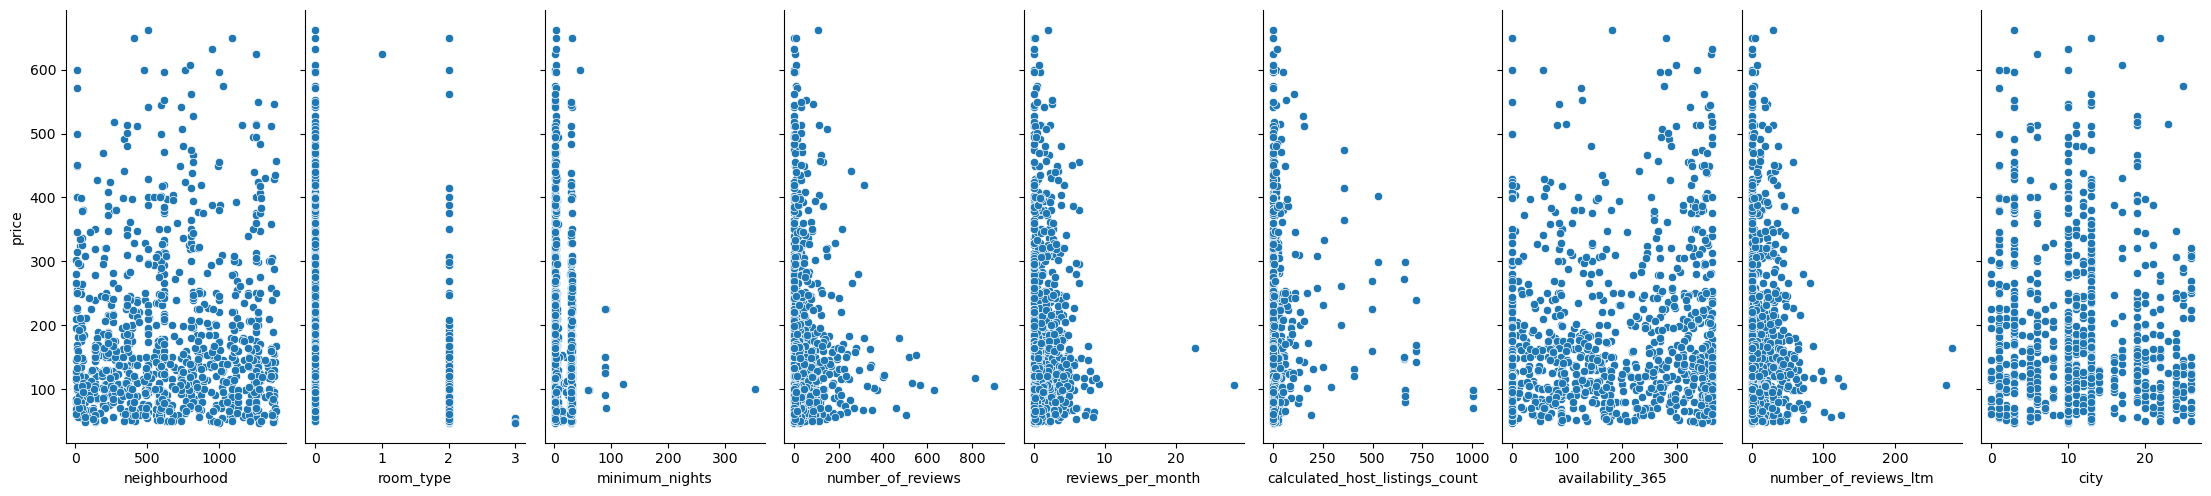

In [24]:
# Visualize relationships between features and target

features = features = df.columns.drop('price').tolist()

sns.pairplot(df.sample(1000), x_vars=features, y_vars='price', height=5, aspect=0.5)
plt.show()


# Model Training


[I 2025-08-03 17:24:54,393] A new study created in memory with name: no-name-e12706ac-9c42-43fd-afa2-61a06e351478
[I 2025-08-03 17:25:20,261] Trial 0 finished with value: 100.29095331217334 and parameters: {'n_estimators': 124, 'max_depth': 13}. Best is trial 0 with value: 100.29095331217334.
[I 2025-08-03 17:26:20,211] Trial 1 finished with value: 98.14189203388743 and parameters: {'n_estimators': 174, 'max_depth': 22}. Best is trial 1 with value: 98.14189203388743.
[I 2025-08-03 17:27:05,033] Trial 2 finished with value: 98.19414679982403 and parameters: {'n_estimators': 129, 'max_depth': 22}. Best is trial 1 with value: 98.14189203388743.
[I 2025-08-03 17:27:23,190] Trial 3 finished with value: 102.90335034442604 and parameters: {'n_estimators': 113, 'max_depth': 10}. Best is trial 1 with value: 98.14189203388743.
[I 2025-08-03 17:27:41,848] Trial 4 finished with value: 107.29923740737496 and parameters: {'n_estimators': 190, 'max_depth': 6}. Best is trial 1 with value: 98.141892033

Best Random Forest params: {'n_estimators': 174, 'max_depth': 22}


[I 2025-08-03 17:35:16,402] Trial 1 finished with value: 95.92842213600983 and parameters: {'n_estimators': 153, 'max_depth': 9, 'learning_rate': 0.11304167497620568}. Best is trial 1 with value: 95.92842213600983.
[I 2025-08-03 17:35:16,675] Trial 2 finished with value: 95.97253216759512 and parameters: {'n_estimators': 101, 'max_depth': 9, 'learning_rate': 0.17226581491914048}. Best is trial 1 with value: 95.92842213600983.
[I 2025-08-03 17:35:17,277] Trial 3 finished with value: 96.32617168387969 and parameters: {'n_estimators': 144, 'max_depth': 10, 'learning_rate': 0.05726309736263459}. Best is trial 1 with value: 95.92842213600983.
[I 2025-08-03 17:35:17,381] Trial 4 finished with value: 104.7546896997135 and parameters: {'n_estimators': 114, 'max_depth': 4, 'learning_rate': 0.04875556049495471}. Best is trial 1 with value: 95.92842213600983.
[I 2025-08-03 17:35:17,499] Trial 5 finished with value: 99.90443448830341 and parameters: {'n_estimators': 156, 'max_depth': 4, 'learning_

Best XGBoost params: {'n_estimators': 153, 'max_depth': 9, 'learning_rate': 0.11304167497620568}


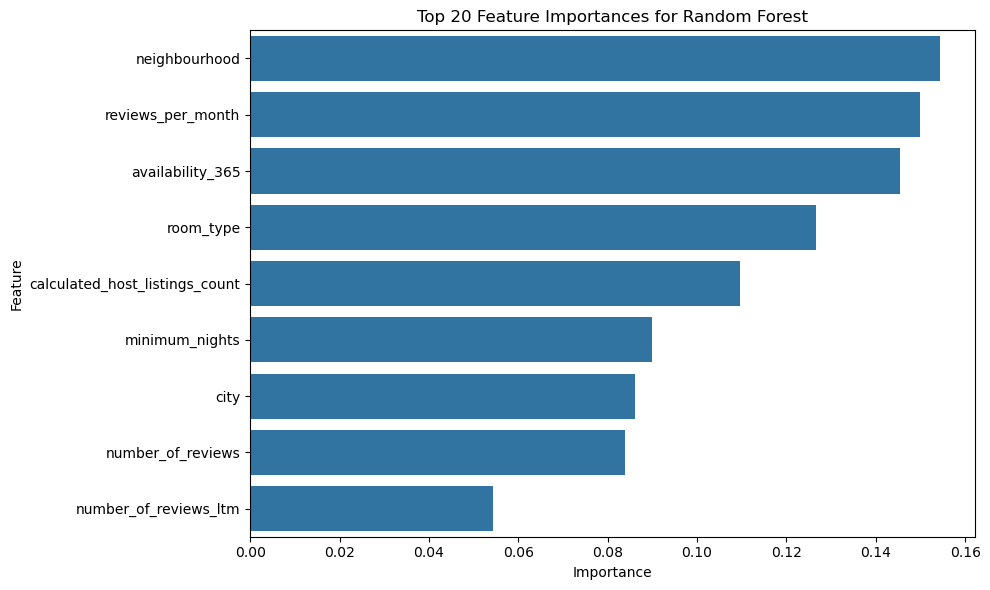

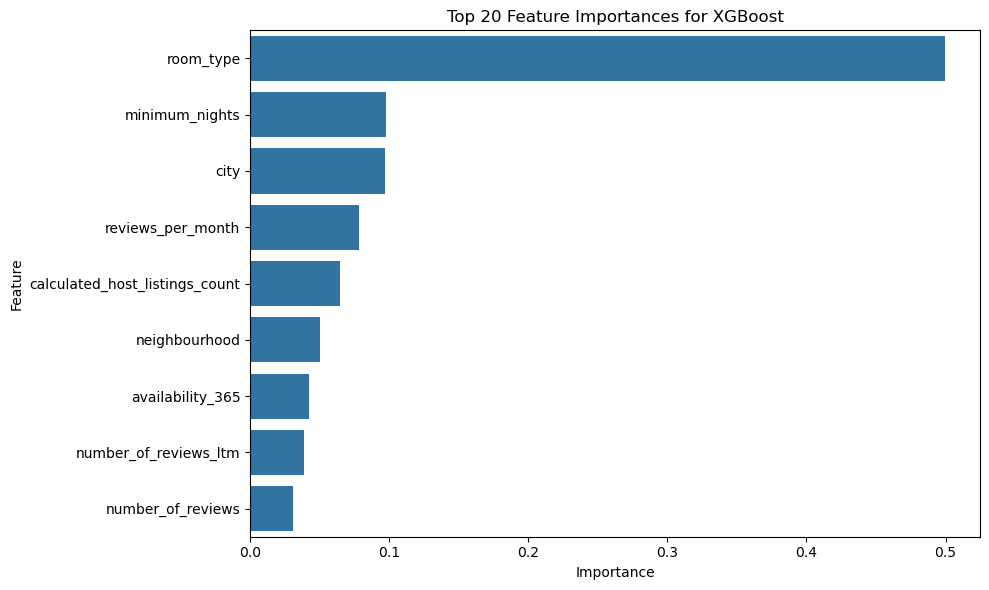

Linear Regression -> RMSE: 113.93, R2: 0.1291
Random Forest -> RMSE: 98.05, R2: 0.3551
XGBoost -> RMSE: 95.87, R2: 0.3834


(95.86963908679064, 0.38338619470596313)

In [26]:
# Create feature and target data frames
X = df.drop(columns='price')  # Features
y = df['price']               # Target variable

# Split data into train_val (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#  Split train_val into train (60%) and val (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)
# (0.8 * 0.25 = 0.2, so total splits: 60% train, 20% val, 20% test)

# Function for bayesian optimisation
def objective(trial, model_name):
    if model_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 5, 30)
        model = RandomForestRegressor(
            n_estimators=n_estimators, max_depth=max_depth, random_state=42
        )
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        model = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=42,
            eval_metric='rmse'
        )
    else:
        raise ValueError("Unsupported model")

    pipeline = Pipeline([('model', model)])
    pipeline.fit(X_train, y_train)
    y_val_pred = pipeline.predict(X_val)
    rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    return rmse

# Tune Random Forest
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(lambda trial: objective(trial, 'RandomForest'), n_trials=15)
print("Best Random Forest params:", study_rf.best_params)

# Tune XGBoost
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(lambda trial: objective(trial, 'XGBoost'), n_trials=15)
print("Best XGBoost params:", study_xgb.best_params)

# Train final models on combined train+val data
X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

# Linear Regression baseline
lr = LinearRegression()
lr.fit(X_final_train, y_final_train)
y_pred_lr = lr.predict(X_test)

# Random Forest final
rf_final = RandomForestRegressor(
    n_estimators=study_rf.best_params['n_estimators'],
    max_depth=study_rf.best_params['max_depth'],
    random_state=42
)
rf_final.fit(X_final_train, y_final_train)
y_pred_rf = rf_final.predict(X_test)

# XGBoost final
xgb_final = XGBRegressor(
    n_estimators=study_xgb.best_params['n_estimators'],
    max_depth=study_xgb.best_params['max_depth'],
    learning_rate=study_xgb.best_params['learning_rate'],
    random_state=42,
    eval_metric='rmse'
)
xgb_final.fit(X_final_train, y_final_train)
y_pred_xgb = xgb_final.predict(X_test)

# Evaluate performance on test set
def print_metrics(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.2f}, R2: {r2:.4f}")
    return rmse, r2

# Plot feature importance for tree models
def plot_feature_importance(model, model_name, feature_names):
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title(f"Top 20 Feature Importances for {model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

feature_names = X.columns

plot_feature_importance(rf_final, "Random Forest", feature_names)
plot_feature_importance(xgb_final, "XGBoost", feature_names)


print_metrics("Linear Regression", y_test, y_pred_lr)
print_metrics("Random Forest", y_test, y_pred_rf)
print_metrics("XGBoost", y_test, y_pred_xgb)
